In [36]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from statistics import median, mean
from matplotlib import pyplot as plt
import numpy as np
import json
from tqdm import tqdm
from glob import glob
import os
import sys
sys.path.insert(0,"/study/mrphys/skunkworks/kk/mriUnet")
from fullmodel import fullModel
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.model_selection import KFold as kf
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from torch.distributed import init_process_group, destroy_process_group
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from mriDataset import mriSliceDataset
from blur import GaussianSmoothing

In [3]:
# Dataset
T1path = sorted(glob('/study/mrphys/skunkworks/training_data/mover01/*/processed_data/T1_3_tv.nii'))
samples = [p.split('/')[6] for p in T1path]
class FullDataset(Dataset):   
    def __getitem__(self, index):
        if index<256:
            return self.xgt[:,index,:,:], self.ymask[:,index,:,:]
        elif index<512:
            index = index-256
            return self.xgt[:,:,index,:], self.ymask[:,:,index,:]
        else:
            index = index-512
            return self.xgt[:,:,:,index], self.ymask[:,:,:,index]
    def __len__(self):
        return 768

In [5]:
folds = {}
kfsplitter = kf(n_splits=5, shuffle=True, random_state=69420)
for i, (train_index, test_index) in enumerate(kfsplitter.split(samples[0:35])):
    folds[i+1] = test_index
    print(f'Fold #{i+1} : {test_index}')

Fold #1 : [ 4 17 20 26 29 32 33]
Fold #2 : [ 2  3  5  8 27 31 34]
Fold #3 : [ 0  1  7 16 18 19 24]
Fold #4 : [ 6  9 12 15 21 22 28]
Fold #5 : [10 11 13 14 23 25 30]


In [44]:
def stack(slicedArray):
    X = slicedArray[0:256]
    Y = slicedArray[256:512]
    Z = slicedArray[512:768]
    X, Y, Z = np.vstack(X).transpose(1,0,2,3), np.vstack(Y).transpose(1,2,0,3), np.vstack(Z).transpose(1,2,3,0)
    return (X+Y+Z)/3

def prediction(model, dataset):
    model.eval()
    predictions = {
        "2 mins pca (gt)":[],
        "9 mins pca (gt)":[],
        "Denoised pca (pred)":[],
        "9 minutes T1 (pred)":[],
        "Denoised T1 (pred)":[],
        "T1 (gt)":[],
        "mask":[],
    }
    for i, data in tqdm(enumerate(dataset)):
        xgt, ymask = data
        x = torch.tensor(xgt).unsqueeze(0)[:,0:10].to(model.device)
        gt = torch.tensor(xgt).unsqueeze(0)[:,10:20].to(model.device)
        y = torch.tensor(ymask).unsqueeze(0)[:,0:1].to(model.device)
        mask = torch.tensor(ymask).unsqueeze(0)[:,1:2].to(model.device)
        # x - 2 mins pca
        # gt - 9 mins pca
        # y - t1 mapping
        # mask - 0,1,2,3 -> bkg,csf,wm,gm
        with torch.no_grad():
            preds, losses, loss = model(x, gt, y, mask.clone())
            denoised_x, y_pred_denoised, y_pred_gt = preds
            addToDict = {
                "2 mins pca (gt)":x.cpu().numpy(),
                "9 mins pca (gt)":gt.cpu().numpy(),
                "Denoised pca (pred)":denoised_x.cpu().numpy(),
                "9 minutes T1 (pred)":y_pred_gt.cpu().numpy(),
                "Denoised T1 (pred)":y_pred_denoised.cpu().numpy(),
                "T1 (gt)":y.cpu().numpy(),
                "mask":mask.cpu().numpy(),
            }
            for key in addToDict.keys():
                predictions[key].append(addToDict[key])
                
    for key in predictions.keys():
        predictions[key] = stack(predictions[key])
                   
    return predictions

In [75]:
fold = 1
gpu_id = 5
name = f"fullModel_{fold}"

model = fullModel().to(gpu_id)
model.load_state_dict(torch.load(f'/study/mrphys/skunkworks/kk/outputs/{name}/weights/{name}_BEST.pth'))
model.device = gpu_id

index = folds[fold][-1]
with open(f'/scratch/mrphys/pickled/fullDataset_{index}.pickle', 'rb') as f:
    dataset = pickle.load(f)

Crop amount [(-4, -4, -4, -4), (-16, -16, -16, -16), (-40, -40, -40, -40)]
Crop amount [(-4, -4, -4, -4), (-16, -16, -16, -16), (-40, -40, -40, -40)]


In [148]:
predictions = prediction(model, dataset)

768it [01:01, 12.43it/s]


In [149]:
# unpack
acc = predictions["2 mins pca (gt)"]
full = predictions["9 mins pca (gt)"]
denoised = predictions["Denoised pca (pred)"]
T1_full = predictions["9 minutes T1 (pred)"]
T1_denoised = predictions["Denoised T1 (pred)"]
T1_gt = predictions["T1 (gt)"]
mask = predictions["mask"]

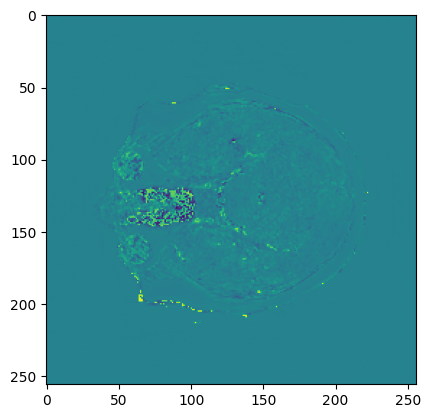

In [150]:
plt.imshow((T1_gt - T1_denoised)[0,100])

In [159]:
#smoothening
smoother = GaussianSmoothing(1, 10, 0.2, 3).to(gpu_id)
def smoothen(pred, mask):
    e = np.copy(pred)
    e[mask==0] = 0.0
    e = smoother(torch.tensor(e).float().to(gpu_id))
    return e.cpu().numpy()
T1_full_s = smoothen(T1_full, mask)
T1_denoised_s = smoothen(T1_denoised, mask)
T1_gt_s = smoothen(T1_gt, mask)

In [160]:
# difference
denoised_diff = full - denoised
T1_diff_full = T1_gt_s - T1_full_s
T1_diff_denoised = T1_gt_s - T1_denoised_s

In [161]:
# percentage diff
T1_diff_full_percentage = T1_diff_full / (T1_gt_s+(mask==0).astype(int))
T1_diff_denoised_percentage = T1_diff_denoised / (T1_gt_s+(mask==0).astype(int))

In [167]:
def meanPMsd(src):
    mean = str(round(np.average(src),2))
    sd = str(round(np.std(src),2))
    return f"{mean} \u00B1 {sd}"

In [178]:
print('Denoised Scan T1 Prediction')
print(f'Region\tT1 difference\tT1 % diff\tT1 abs diff\tT1 % abs diff')
cond = mask!=0
print(f'Brain\t{meanPMsd(T1_diff_denoised[cond]*1000)}\t{meanPMsd(T1_diff_denoised_percentage[cond]*100)}\t{meanPMsd(np.abs(T1_diff_denoised[cond]*1000))}\t{meanPMsd(np.abs(T1_diff_denoised_percentage[cond]*100))}')
cond = mask==2
print(f'GM\t{meanPMsd(T1_diff_denoised[cond]*1000)}\t{meanPMsd(T1_diff_denoised_percentage[cond]*100)}\t{meanPMsd(np.abs(T1_diff_denoised[cond]*1000))}\t{meanPMsd(np.abs(T1_diff_denoised_percentage[cond]*100))}')
cond = mask==3
print(f'WM\t{meanPMsd(T1_diff_denoised[cond]*1000)}\t{meanPMsd(T1_diff_denoised_percentage[cond]*100)}\t{meanPMsd(np.abs(T1_diff_denoised[cond]*1000))}\t{meanPMsd(np.abs(T1_diff_denoised_percentage[cond]*100))}')
print('\nFull Scan T1 Prediction')
print(f'Region\tT1 difference\tT1 % diff\tT1 abs diff\tT1 % abs diff')
cond = mask!=0
print(f'Brain\t{meanPMsd(T1_diff_full[cond]*1000)}\t{meanPMsd(T1_diff_full_percentage[cond]*100)}\t{meanPMsd(np.abs(T1_diff_full[cond]*1000))}\t{meanPMsd(np.abs(T1_diff_full_percentage[cond]*100))}')
cond = mask==2
print(f'GM\t{meanPMsd(T1_diff_full[cond]*1000)}\t{meanPMsd(T1_diff_full_percentage[cond]*100)}\t{meanPMsd(np.abs(T1_diff_full[cond]*1000))}\t{meanPMsd(np.abs(T1_diff_full_percentage[cond]*100))}')
cond = mask==3
print(f'WM\t{meanPMsd(T1_diff_full[cond]*1000)}\t{meanPMsd(T1_diff_full_percentage[cond]*100)}\t{meanPMsd(np.abs(T1_diff_full[cond]*1000))}\t{meanPMsd(np.abs(T1_diff_full_percentage[cond]*100))}')

Denoised Scan T1 Prediction
Region	T1 difference	T1 % diff	T1 abs diff	T1 % abs diff
Brain	40.09 ± 126.51	2.15 ± 6.78	87.38 ± 99.89	5.41 ± 4.62
GM	45.7 ± 112.19	2.48 ± 6.66	91.23 ± 79.7	5.55 ± 4.44
WM	21.17 ± 63.92	1.63 ± 5.28	50.03 ± 45.07	4.31 ± 3.45

Full Scan T1 Prediction
Region	T1 difference	T1 % diff	T1 abs diff	T1 % abs diff
Brain	12.74 ± 70.71	0.49 ± 3.82	46.83 ± 54.5	2.9 ± 2.54
GM	16.63 ± 64.01	0.84 ± 3.81	49.5 ± 43.85	3.02 ± 2.46
WM	-2.17 ± 34.05	-0.3 ± 2.84	25.62 ± 22.54	2.23 ± 1.78


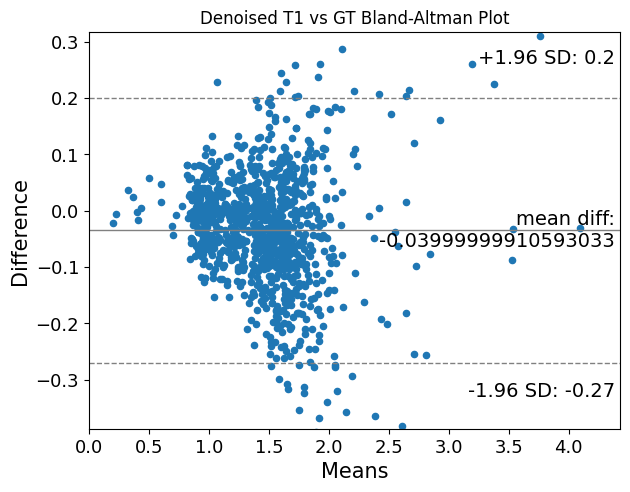

In [88]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

import pandas as pd

values = T1_denoised_s[mask!=0]
groundtruth = T1_gt_s[mask!=0]
i = np.random.choice(np.arange(len(values)),1000,replace=False)

df = pd.DataFrame({'A': list(values[i]),
                   'B': list(groundtruth[i])})

#create Bland-Altman plot                  
fig, ax = plt.subplots(1)
sm.graphics.mean_diff_plot(df.A, df.B, ax = ax)

#display Bland-Altman plot
plt.title("Denoised T1 vs GT Bland-Altman Plot")
plt.show()

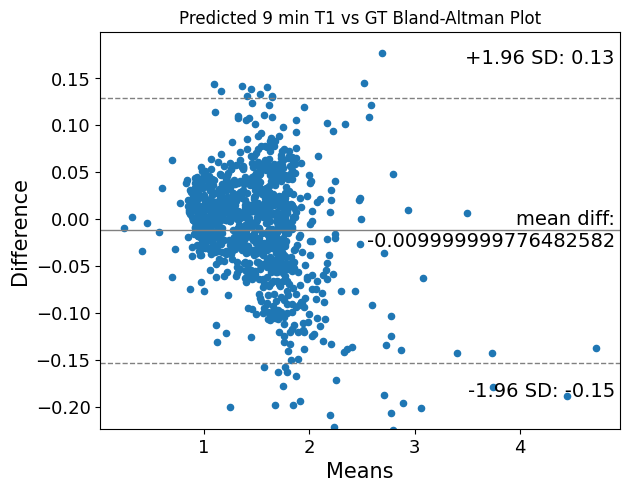

In [89]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

import pandas as pd

values = T1_full_s[mask!=0]
groundtruth = T1_gt_s[mask!=0]
i = np.random.choice(np.arange(len(values)),1000,replace=False)

df = pd.DataFrame({'A': list(values[i]),
                   'B': list(groundtruth[i])})

#create Bland-Altman plot                  
fig, ax = plt.subplots(1)
sm.graphics.mean_diff_plot(df.A, df.B, ax = ax)

#display Bland-Altman plot
plt.title("Predicted 9 min T1 vs GT Bland-Altman Plot")
plt.show()